## Regulatory Module
For this analysis, we first detect key TF-TG subnetworks (modules) from the cell population TF–TG trans-regulation. Then, we identify the differential regulatory modules differentially expressed from the case and control groups.  
在这项分析中，我们首先从细胞群 TF-TG 跨调控中检测关键的 TF-TG 子网络（模块）。然后，我们找出病例组和对照组中表达不同的差异调控模块。

## Detect Module
**Input**
1. pseudobulk gene expression: [TG_pseudobulk], please make sure the data is after removing batch effect
2. metadata including case and control in column 'group' and cell type annotation in column 'celltype': [metadata]. Note that the case is 1 and the control is 0.
3. LINGER outdir including a trans-regulatory network, 'cell_population_trans_regulatory.txt',
4. GWAS data file, which is not necessary.

This is an example of the input.

In [ ]:
import pandas as pd
TG_pseudobulk = pd.read_csv('data/TG_pseudobulk.tsv',sep=',',header=0,index_col=0)
TG_pseudobulk = TG_pseudobulk[~TG_pseudobulk.index.str.startswith('MT-')] # remove the mitochondrion, if the specie is mouse, replace 'MT-' with 'mt-'
import scanpy as sc
adata_RNA = sc.read_h5ad('data/adata_RNA.h5ad')
label_all = adata_RNA.obs[['barcode','sample','label']]
label_all.index = label_all['barcode']
metadata = label_all.loc[TG_pseudobulk.columns]
metadata.columns = ['barcode','group','celltype']
outdir = 'output/'
GWASfile = ['AUD_gene.txt','AUD_gene2.txt']# GWAS file is a gene list with no head (Optional)

TG_pseudobulk  
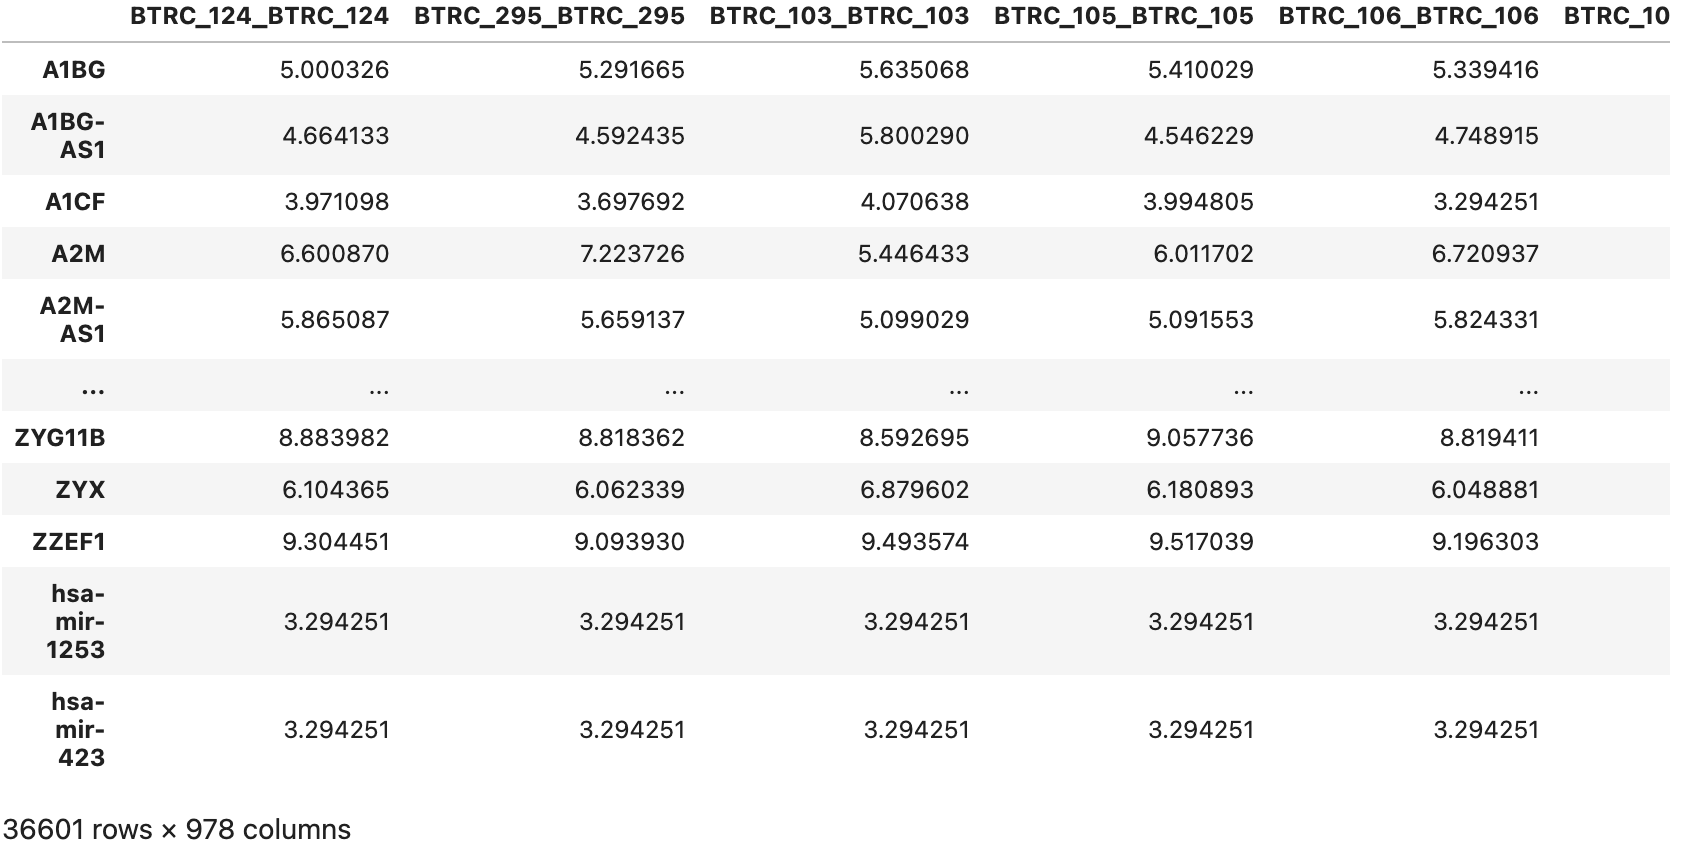

metadata  
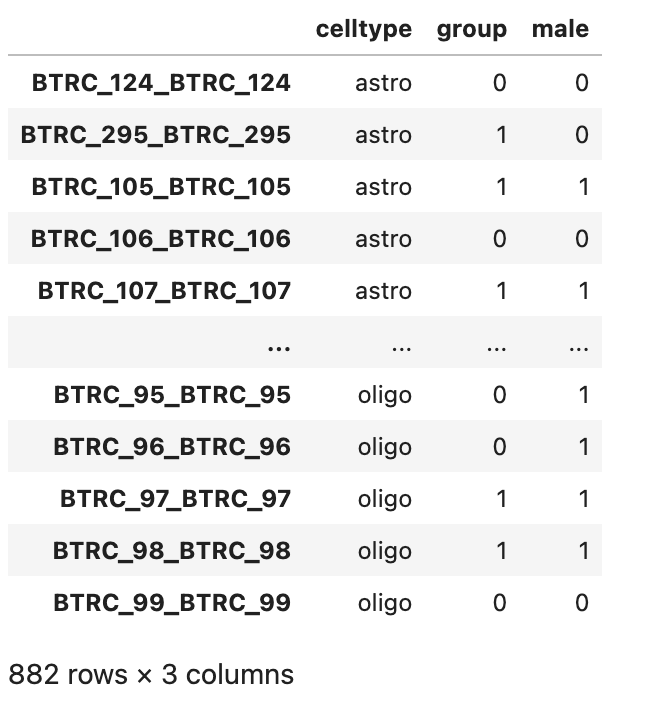

### output


In [ ]:
K=10 #k is the number of modules, a tunning parameter
from LingerGRN import Compare
Module_result=Compare.Module_trans(outdir,metadata,TG_pseudobulk,K,GWASfile)

The output is Module_result object. There are 3 items in this object:

1. S_TG, which representing the module assigned for eahc gene;
2. pvalue_all, the p-value of the differential module t-test comparing the case and control groups;
3. t_value, the t-value of the t-test, positive value representing group 1 is more active, and negative value representing group 0 is more active.

1. Module_result.S_TG
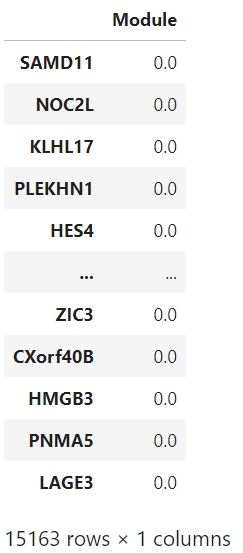

2. Module_result.pvalue_all
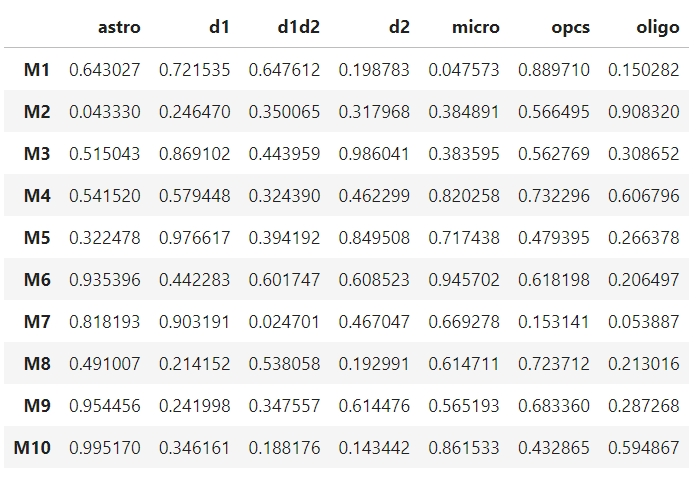

3. Module_result.tvalue_all
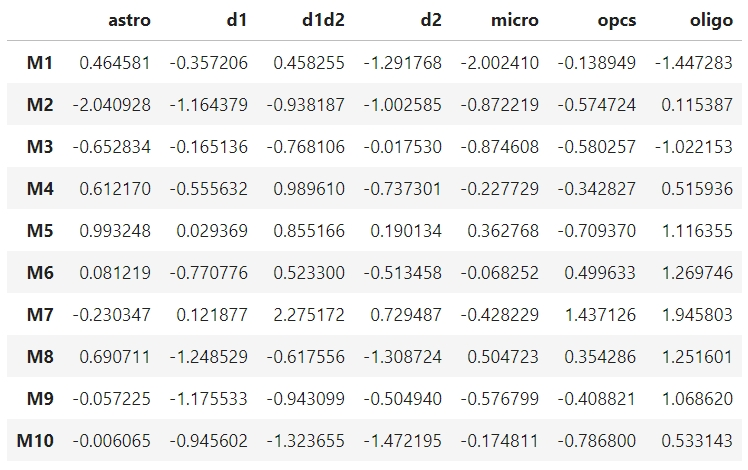

### Save the result to files.

In [ ]:
Module_result.pvalue_all.to_csv('pvalue_all.txt',sep='\t')
Module_result.tvalue_all.to_csv('tvalue_all.txt',sep='\t')
temp=Module_result.S_TG
temp=temp[temp['Module']>0]
temp.to_csv('Module.txt',sep='\t')

### Visualize
Please ensure that the r packages: ggplot2, grid, tidyr, egg are well-installed. Note that 'cutoff' is a parameter, representing the cutoff of -log10(p-value). We suggest 'cutoff = 2' as a default.

In [ ]:
# Import the rpy2 components needed
import os
os.environ['R_HOME'] = '/data2/duren_lab/Kaya/conda_envs/LINGER/lib/R'  # Replace with your actual R home path
import rpy2.robjects as robjects
from rpy2.robjects import r

# Import the R plotting package (ggplot2 as an example)
r('library(ggplot2)')
r('library(grid)')
# Create data in R environment through Python
r('''
library(tidyr)
dataP=read.table('pvalue_all.txt',sep='\t',header=TRUE,row.names=1)
dataT=read.table('tvalue_all.txt',sep='\t',header=TRUE,row.names=1)
dataP=-log10(dataP)
dataP$TF=rownames(dataP)
dataT$TF=rownames(dataT)
longdiff0 <- gather(dataP, sample, value,-TF)
longdiff1 <- gather(dataT, sample, value,-TF)
colnames(longdiff1)=c('TF','celltype','T')
longdiff1$P=longdiff0$value
longdiff1$TF=factor(longdiff1$TF,levels=rev(longdiff1$TF[1:10]))
print(longdiff1[1:10,])
''')
# R code for plotting using ggplot
r('''
cutoff=1 # here 
maxp=ceiling(max(longdiff1$P))
limits0=c(cutoff,maxp)
range0=c(1,(maxp-cutoff+1))*4/(maxp-cutoff+1)
breaks0=(cutoff+1):(maxp-1)
print(limits0)
print(range0)
print(breaks0)
''')

# Print the plot to display it
r('''
library(ggplot2)
library(egg)
p=ggplot(longdiff1,aes(x = celltype, y = TF))+
geom_point(aes(size = P, fill = T), alpha = 1, shape = 21) + 
  scale_size_continuous(limits = limits0, range = range0, breaks = breaks0) + 
  labs( x= "cell type", y = "Module", fill = "")  + theme_article()+
  theme(legend.key=element_blank(), 
  axis.text.x = element_text(colour = "black", size = 9, face = "bold", angle = 90, vjust = 0.3, hjust = 1), 
  axis.text.y = element_text(colour = "black", face = "bold", size = 11), 
  legend.text = element_text(size = 9, face ="bold", colour ="black"), 
  legend.title = element_text(size = 9, face = "bold"), 
  panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, size = 1.2), 
  legend.position = "right") +  
  scale_fill_gradient2(midpoint=0, low="blue", mid="white",
                     high="red", space ="Lab" )
''')
r("pdf('module_result.pdf',width=1.5+dim(dataP)[2]/3,height=3)")# change the height and the width of the figure
r('print(p)')
r('dev.off()')

The figure is saved to module_result.pdf.
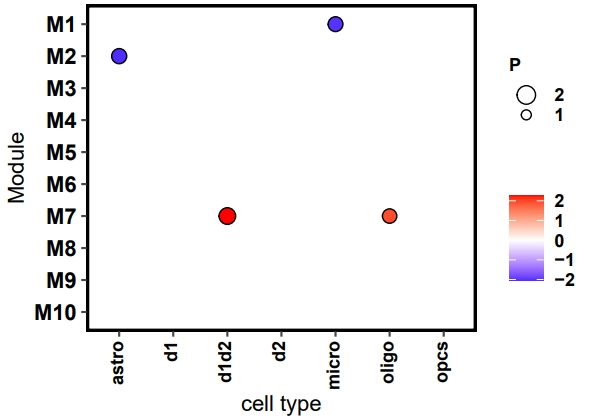